In [1]:
from differentiable_t1d.utils import initialize_patient, Params, generate_meals_and_insulin_events
from differentiable_t1d.uva_padova_jax import observe_blood_glucose, observe_subcutaneous_glucose, uva_padova_2008_dynamics, square_controls

import jax
import jax.numpy as jnp
import numpy as np
params, unused_params, init_state = initialize_patient("adult#001", to_tensors=False)

/home/alex/repos/hybrid_t1d_ode/myvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading patient adult#001


In [2]:
from functools import partial
from jax.tree_util import Partial as jpartial


def make_controller_params(meals, doses, bw, dt, eating_rate=5.0):
    """
    Assumes:
    meal times in minutes, meal amounts in g, insulin doses in U, bw in kg
    eating_rate in g/min
    dt in minutes
    """
    # compute meal duration
    meal_widths = meals[:, 1] / eating_rate  # minutes
    meal_times = meals[:, 0]  # time in minutes
    # make eating rate the amplitude of our meal controller
    meal_amplitudes = eating_rate * np.ones_like(meals[:, 1])  # g/min
    # convert to mg/min
    meal_amplitudes = meal_amplitudes * 1000.0

    insulin_widths = dt # mins; assume injection time is constant 
    insulin_times = doses[:, 0]  # time in minutes
    # convert U to pmols/kg
    insulin_amplitudes = doses[:, 1] * 6000 / bw
    # convert to pmols/kg/min
    insulin_amplitudes = insulin_amplitudes / insulin_widths
    insulin_widths = insulin_widths * np.ones_like(insulin_amplitudes)

    meal_controller = jpartial(square_controls, meal_widths, meal_amplitudes, meal_times) 
    insulin_controller = jpartial(square_controls, insulin_widths, insulin_amplitudes, insulin_times)
    return meal_controller, insulin_controller

In [3]:
%%time
t0 = jnp.array(0.)
num_days = 3
t1 = 60. * 24 * num_days # 24 hours in minutes
dt = 1.0   # IMPORANT: this can't be too large or else the integration will diverge (ex when t=5.)
T = int((t1 - t0) / dt) + 1
icr = unused_params["CR"] 
cf = unused_params["CF"] 
target_bg = 140.

basal_rate = unused_params["u2ss"] # u2ss is in pmols/kg/min

meals, doses = generate_meals_and_insulin_events(icr=icr, bw=params.BW.item(), num_days=num_days, seed=0)

uva_padova_2008_dynamics = jax.jit(uva_padova_2008_dynamics)  # jit not needed if we lax.scan

u_m, u_i = make_controller_params(meals, doses, bw=params.BW, dt=dt)

def step(state, i):
    t = t0 + dt * i
    carbs = u_m(t)
    bg = observe_blood_glucose(params, state)

    cr_dose = u_i(t)
    cf_dose = (cr_dose > 0) * (bg - target_bg) / cf
    dose = cr_dose + cf_dose
    insulin = dose + basal_rate
    insulin = jnp.clip(insulin, a_min=0.)

    dstate_dt, _ = uva_padova_2008_dynamics(params, t, state, carbs, insulin)
    state = state + dstate_dt * dt
    return state, state

_, states = jax.lax.scan(step, init_state, jnp.arange(1, T))  # without scan, this took 10s using python for loops!
states.block_until_ready()
states = jnp.concatenate([init_state[None, :], states], axis=0)

CPU times: user 200 ms, sys: 12.6 ms, total: 212 ms
Wall time: 200 ms


In [4]:
q_sto1, q_sto2, q_gut, G_p, G_t, I_p, X, I_1, I_d, I_l, I_sc1, I_sc2, Gs = states.T

[Text(0, 0.5, 'Gs')]

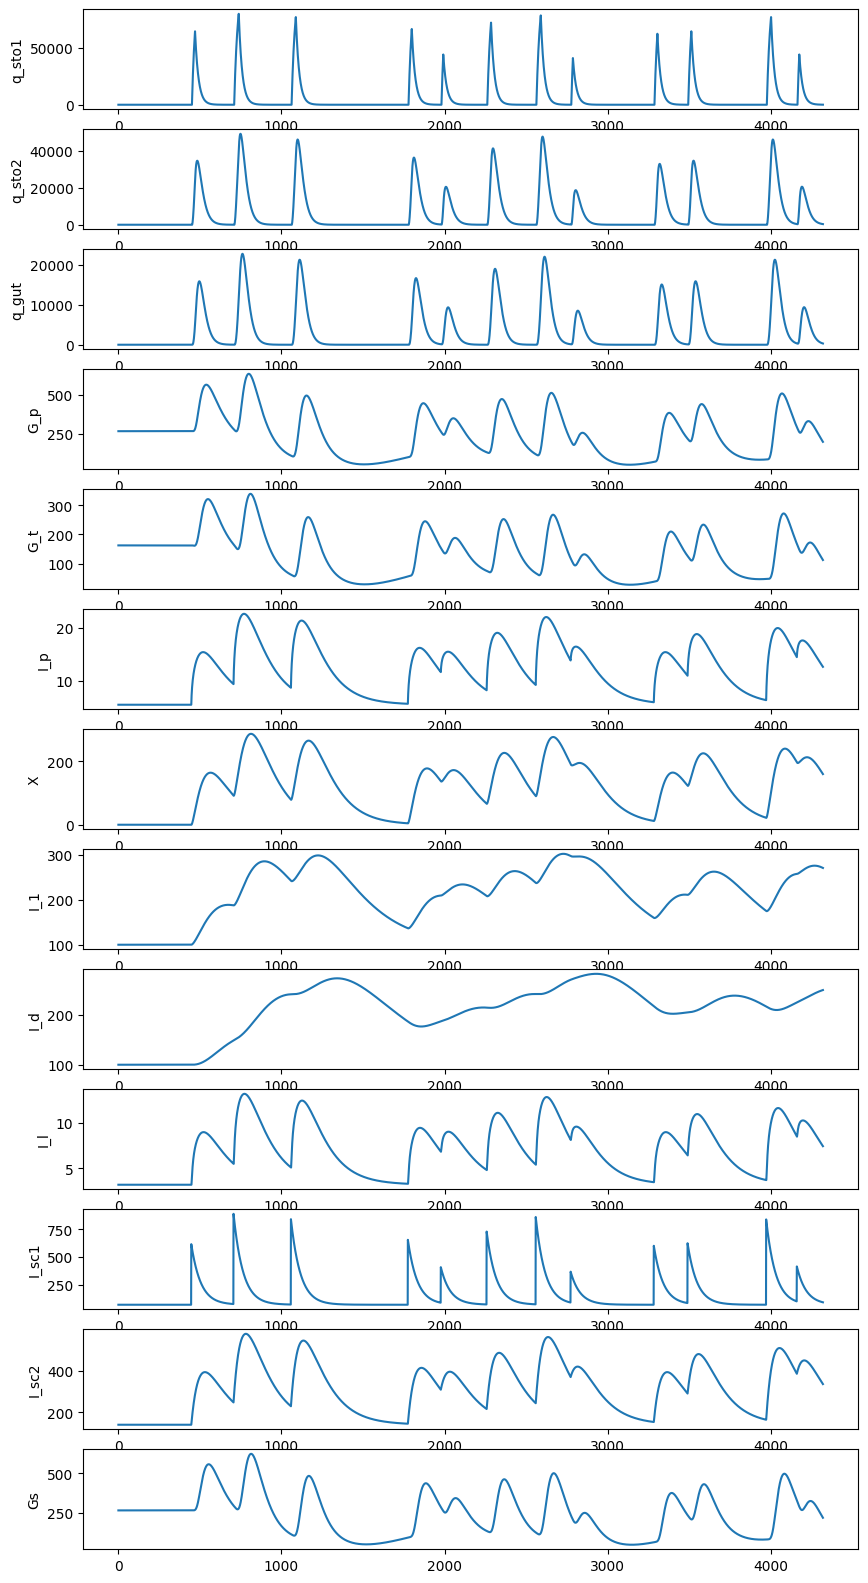

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(13, 1, figsize=(10, 20))
ax[0].plot(q_sto1)
ax[0].set(ylabel="q_sto1")
ax[1].plot(q_sto2)
ax[1].set(ylabel="q_sto2")
ax[2].plot(q_gut)
ax[2].set(ylabel="q_gut")
ax[3].plot(G_p)
ax[3].set(ylabel="G_p")
ax[4].plot(G_t)
ax[4].set(ylabel="G_t")
ax[5].plot(I_p)
ax[5].set(ylabel="I_p")
ax[6].plot(X)
ax[6].set(ylabel="X")
ax[7].plot(I_1)
ax[7].set(ylabel="I_1")
ax[8].plot(I_d)
ax[8].set(ylabel="I_d")
ax[9].plot(I_l)
ax[9].set(ylabel="I_l")
ax[10].plot(I_sc1)
ax[10].set(ylabel="I_sc1")
ax[11].plot(I_sc2)
ax[11].set(ylabel="I_sc2")
ax[12].plot(Gs)
ax[12].set(ylabel="Gs")

[(0.0, 300.0)]

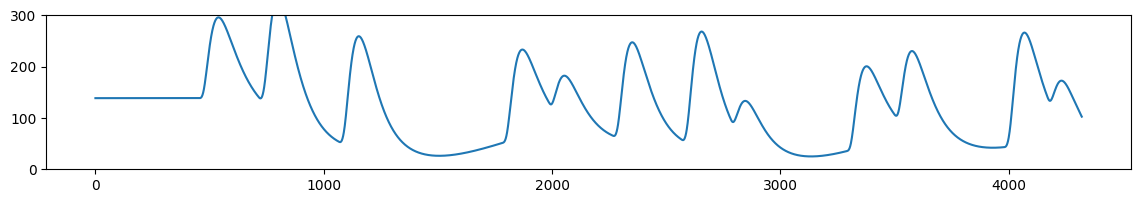

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
G = observe_blood_glucose(params, states)
ax.plot(G)
ax.set(ylim=[0, 300])

[(0.0, 300.0)]

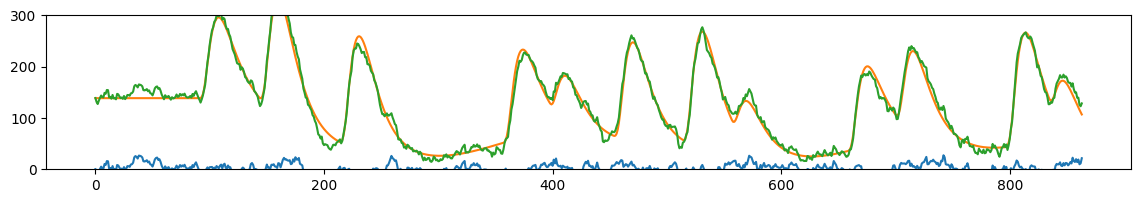

In [7]:
# try adding autoregressive noise similar to what you might get from a CGM
# also subsample to be every 5 mins

noise = jax.random.normal(jax.random.PRNGKey(0) ,(len(G) // 5,)) * 5 
noise = np.array(noise)
for i in range(1, len(noise)):
    noise[i] = noise[i] + 0.9 * noise[i - 1]

fig, ax = plt.subplots(1, 1, figsize=(14, 2))

noisy_G = np.array(noise.copy())
G_subsampled = np.array(noise.copy())
for i in range(len(noisy_G)):
    noisy_G[i] = noisy_G[i] + G[i * 5]
    G_subsampled[i] = G[i * 5]

ax.plot(noise)
ax.plot(G_subsampled)
ax.plot(noisy_G)
ax.set(ylim=[0, 300])